In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap
import warnings

from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (8,5)
RANDOM_STATE = 42
class_names = ["Normal", "DoS", "Probe", "Privilege"]

In [14]:
print("Loading Data...")

X_train = np.load("../data/processed/X_train.npy")
X_test = np.load("../data/processed/X_test.npy")
y_train = np.load("../data/processed/y_train.npy")
y_test = np.load("../data/processed/y_test.npy")

Loading Data...


In [15]:
print("Loading Ultimate Pipeline Artifacts...")

meta_model = tf.keras.models.load_model("../outputs/models/meta_model_ultimate.keras")
base_models = joblib.load("../outputs/models/fast_base_models.pkl")
class_weights = joblib.load("../outputs/models/ultimate_class_weights.pkl")
threshold_data = joblib.load("../outputs/models/optimal_thresholds.pkl")

class_3_multiplier = threshold_data.get('class_3_multiplier', 1.0)

# Load feature names if available
try:
    selector = joblib.load("../outputs/models/feature_selector.pkl")
    original_feature_names = selector.get_feature_names_out()
except:
    original_feature_names = np.array([f"Feature_{i}" for i in range(X_train.shape[1])])

print(f"✅ All artifacts loaded. (Class 3 Multiplier: {class_3_multiplier}x)")

Loading Ultimate Pipeline Artifacts...
✅ All artifacts loaded. (Class 3 Multiplier: 1.0x)


In [16]:
feature_descriptions = {
    "duration": "Connection Length (sec)",
    "protocol_type_tcp": "TCP Protocol",
    "protocol_type_udp": "UDP Protocol",
    "protocol_type_icmp": "ICMP Protocol",
    "service_http": "HTTP Web Traffic",
    "service_private": "Private Port Traffic",
    "flag_SF": "Normal Teardown (SF)",
    "flag_S0": "No Reply (S0)",
    "flag_REJ": "Connection Rejected (REJ)",
    "src_bytes": "Bytes from Source",
    "dst_bytes": "Bytes from Destination",
    "wrong_fragment": "Fragmented Packet Errors",
    "hot": "Suspicious Content ('Hot')",
    "num_failed_logins": "Failed Logins",
    "logged_in": "Successful Login",
    "num_compromised": "Compromised Conditions",
    "root_shell": "Root Shell Accessed",
    "count": "Connections to Same Host (2s)",
    "srv_count": "Connections to Same Service (2s)",
    "serror_rate": "SYN Error Rate",
    "rerror_rate": "REJ Error Rate",
    "same_srv_rate": "Same Service %",
    "dst_host_count": "Dest. Host Connections",
    "dst_host_srv_count": "Dest. Host Same-Service Count",
    "dst_host_same_srv_rate": "Dest. Host Same-Service %",
    "dst_host_diff_srv_rate": "Dest. Host Diff-Service %"
}

readable_feature_names = []
for name in original_feature_names:
    matched = False
    for key, desc in feature_descriptions.items():
        if key in name:
            readable_feature_names.append(desc)
            matched = True
            break
    if not matched:
        readable_feature_names.append(name)

readable_feature_names = np.array(readable_feature_names)

In [17]:
def pipeline_predict_proba(X_instances):
    """Full hybrid pipeline prediction"""
    
    n_instances = X_instances.shape[0]
    n_models = len(base_models)
    n_classes = 4
    
    meta_features = np.zeros((n_instances, n_models * n_classes))
    
    # Base models
    for i, model in enumerate(base_models):
        meta_features[:, i*n_classes:(i+1)*n_classes] = model.predict_proba(X_instances)
    
    # Meta learner
    raw_probs = meta_model.predict(meta_features, verbose=0)
    
    # Apply multiplier
    adj_probs = raw_probs.copy()
    adj_probs[:, 3] *= class_3_multiplier
    
    # ⭐ normalize (important)
    adj_probs = adj_probs / adj_probs.sum(axis=1, keepdims=True)
    
    return adj_probs


def pipeline_predict(X_instances):
    return np.argmax(pipeline_predict_proba(X_instances), axis=1)

In [18]:
print("Generating surrogate training targets from full pipeline...")

y_train_pipeline = pipeline_predict(X_train)

print("Training Surrogate Explainer (Fast Random Forest)...")

surrogate_rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    class_weight=class_weights,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

surrogate_rf.fit(X_train, y_train_pipeline)

print("Computing SHAP values...")
explainer = shap.TreeExplainer(surrogate_rf)

# ⭐ FIXED: sample from TRAIN (not test)
X_background = shap.sample(X_train, 1500)

shap_values_global = explainer.shap_values(X_background)

print("✅ SHAP computation complete.")

Generating surrogate training targets from full pipeline...
Training Surrogate Explainer (Fast Random Forest)...
Computing SHAP values...
✅ SHAP computation complete.



📊 GLOBAL FEATURE IMPORTANCE


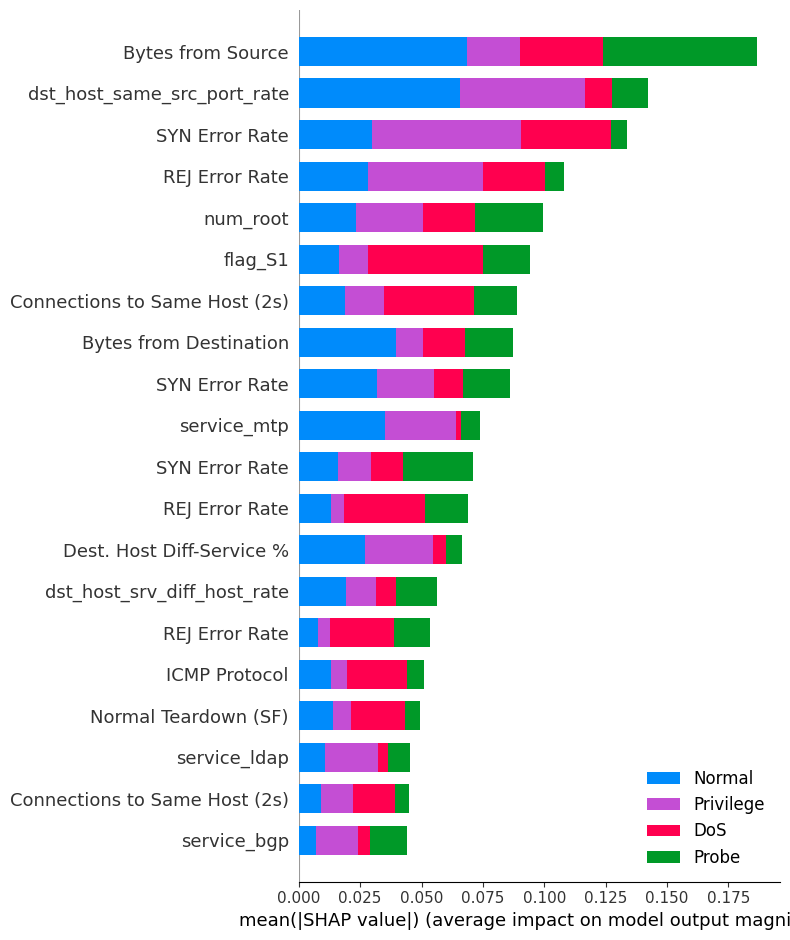

In [19]:
print("\n" + "="*40)
print("📊 GLOBAL FEATURE IMPORTANCE")
print("="*40)

shap.summary_plot(
    shap_values_global,
    X_background,
    feature_names=readable_feature_names,
    plot_type="bar",
    class_names=class_names
)

In [20]:
def explain_attack_ultimate(sample_id=0, top_k=5):
    X_instance = X_test[sample_id:sample_id+1]
    true_label = class_names[y_test[sample_id]]
    
    # TRUE pipeline prediction
    adj_probs = pipeline_predict_proba(X_instance)[0]
    pred_class = np.argmax(adj_probs)
    pred_label = class_names[pred_class]
    
    print("\n" + "="*55)
    print("🛡️ AUTOMATED CYBER-ANALYST INCIDENT REPORT")
    print("="*55)
    print(f"📡 Packet ID:      {sample_id}")
    print(f"🎯 True Status:    {true_label}")
    print(f"🤖 AI Prediction:  {pred_label}\n")
    
    print("🧠 Network Confidence (Adjusted):")
    for i, p in enumerate(adj_probs):
        marker = " 👈 (Selected)" if i == pred_class else ""
        '''print(f"   • {class_names[i]:<10}: {p*100:>5.1f}% {marker}")'''
        print(f"   • {class_names[i]:<10}: {p*100:>6.3f}% {marker}")
    if class_3_multiplier > 1.0 and pred_class == 3:
        print(f"\n⚠️ SYSTEM NOTE: Flagged using high-sensitivity Privilege threshold ({class_3_multiplier}x).")

    # SHAP local
    shap_vals_local = explainer.shap_values(X_instance)
    
    if isinstance(shap_vals_local, list):
        shap_for_pred = shap_vals_local[pred_class][0]
        base_val = explainer.expected_value[pred_class]
    else:
        shap_for_pred = shap_vals_local[0, :, pred_class]
        base_val = explainer.expected_value[pred_class]
        
    contrib = pd.DataFrame({
        "Feature": readable_feature_names,
        "Value": X_instance[0],
        "SHAP": shap_for_pred
    })
    
    contrib["Abs"] = np.abs(contrib["SHAP"])
    top_contribs = contrib.sort_values("Abs", ascending=False).head(top_k)
    
    print("\n🔍 FORENSIC BREAKDOWN (Why the AI chose this):")
    print(f"The traffic was classified as '{pred_label}' primarily because of:\n")
    
    for _, row in top_contribs.iterrows():
        '''direction = "INCREASED" if row["SHAP"] > 0 else "DECREASED"'''
        direction = "positively contributed to" if row["SHAP"] > 0 else "negatively contributed to"
        val = row['Value']
        val_str = f"{val:.2f}" if isinstance(val, float) else str(val)
        
        print(f"  ➤ {row['Feature']} (Observed: {val_str})")
        print(f"      Impact: This {direction} the prediction of {pred_label}.")
        
    print("="*55)
    
    print("\n📊 VISUAL SHAP WATERFALL PLOT:")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_for_pred,
            base_values=base_val,
            data=X_instance[0],
            feature_names=readable_feature_names
        )
    )


🛡️ AUTOMATED CYBER-ANALYST INCIDENT REPORT
📡 Packet ID:      100
🎯 True Status:    Probe
🤖 AI Prediction:  Probe

🧠 Network Confidence (Adjusted):
   • Normal    :  0.001% 
   • DoS       :  0.000% 
   • Probe     : 99.999%  👈 (Selected)
   • Privilege :  0.000% 

🔍 FORENSIC BREAKDOWN (Why the AI chose this):
The traffic was classified as 'Probe' primarily because of:

  ➤ SYN Error Rate (Observed: 4.85)
      Impact: This positively contributed to the prediction of Probe.
  ➤ Connections to Same Host (2s) (Observed: 5.20)
      Impact: This positively contributed to the prediction of Probe.
  ➤ Bytes from Source (Observed: -0.01)
      Impact: This positively contributed to the prediction of Probe.
  ➤ REJ Error Rate (Observed: -0.62)
      Impact: This positively contributed to the prediction of Probe.
  ➤ TCP Protocol (Observed: 2.84)
      Impact: This positively contributed to the prediction of Probe.

📊 VISUAL SHAP WATERFALL PLOT:


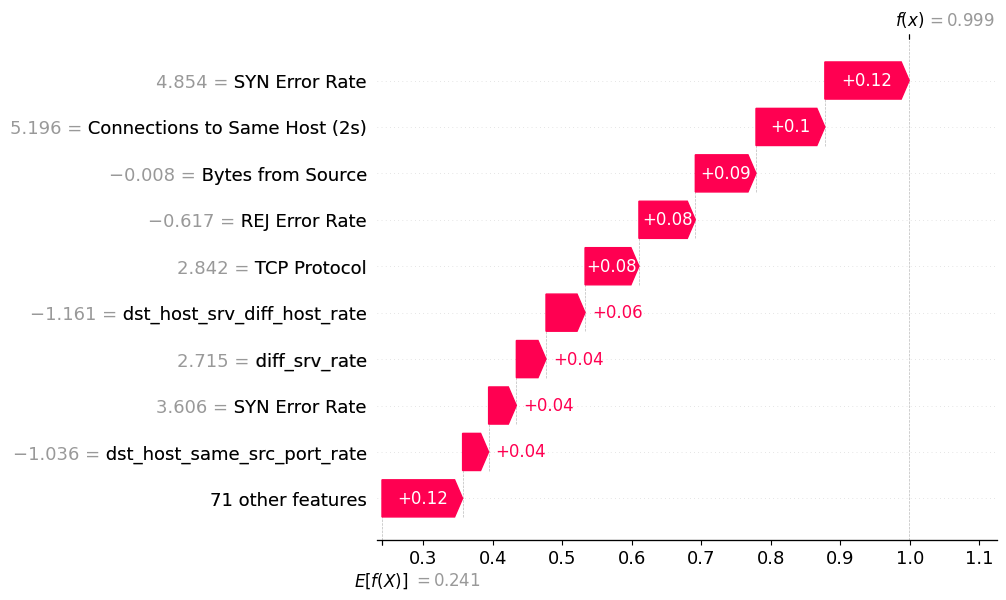

In [21]:
# Test explanation
explain_attack_ultimate(sample_id=100)

In [22]:
joblib.dump(surrogate_rf, "../outputs/models/surrogate_model.pkl")
joblib.dump(explainer, "../outputs/models/shap_explainer.pkl")

['../outputs/models/shap_explainer.pkl']